# Order 2 methods for unconstrained optimization

In [1]:
# This doesn't work with Jupyter Lab (as of October 2018), please use Jupyter Notebook
%matplotlib notebook 

We will be studying the Rosenbrock function along with it's gradient, just like for the [first lab](optimization-part-1).

In [2]:
import numpy as np


def f(X, a=1, b=10):
    (x0, x1) = X
    return (x0 - a) ** 2 + b * (x0 ** 2 - x1) ** 2


def g(X, a=1, b=10):
    (x0, x1) = X
    
    dx0 = 2*(x0-a) + 4*b*x0 * (x0**2-x1)
    dx1 = -2*b * (x0**2 - x1)
    
    return np.array([dx0, dx1])

We will also be needing the Hessian.

$$\begin{cases}
\frac{\partial f}{\partial x_0 \partial x_0} = 2 + 4b(x_0^2-x_1) + 8bx_0^2 \\
\frac{\partial f}{\partial x_0 \partial x_1} = -4bx_0 \\
\frac{\partial f}{\partial x_1 \partial x_0} = -4bx_0 \\
\frac{\partial f}{\partial x_1 \partial x_1} = 2b
\end{cases}$$

In [3]:
def h(X, a=1, b=10):
    (x0, x1) = X
    
    dx0x0 = 2 + 4*b* (x0*x0 - x1) + 8*b*x0*x0
    dx0x1 = -4*b*x0
    dx1x0 = -4*b*x0
    dx1x1 = 2*b
    
    return np.array([
        [dx0x0, dx0x1],
        [dx1x0, dx1x1]
    ])

h([-1, 1])

array([[82, 40],
       [40, 20]])

We'll reuse the gradient descent with line search that we used in the first lab. However we will be adding a stopping condition so that the search stops if the norm of the gradient becomes lower than a provided value called `eps`. We'll adapt the naming and the output trace to handle the case where the optimization stops prematuraly. For example we will rename `n_iterations` to `max_iterations` because it makes more sense semantically. Also we are going to feed the line searcher with the descent direction instead of the gradient. This will make sense later on.

In [4]:
class LineSearchGD():
    
    def __init__(self, X0, ls, max_iterations, eps):
        self.X0 = np.array(X0, dtype=float)
        self.ls = ls
        self.max_iterations = max_iterations
        self.eps = eps
        
    def optimize(self, f, g):
        
        X = self.X0.copy()
        trace = [X.copy()]
        steps = [0]

        for _ in range(self.max_iterations):

            # Compute the gradient
            gradient = g(X)
            
            # Stop if the norm of the gradient is lower than eps
            if np.dot(gradient, gradient) < self.eps:
                break

            # Find the optimal step size
            direction = -gradient
            step = self.ls.find_step(f, direction, X)

            # Move X along the descent direction
            X += step * direction

            # Store the new position and the new step size 
            trace.append(X.copy())
            steps.append(step)

        return np.array(trace), np.array(steps)

We will also reuse the Armijo line searcher we implemented in the previous lab. The only difference is that we provide it with the descent direction instead of the gradient.

In [5]:
class ArmijoLineSearch():
    
    def __init__(self, c, max_step):
        self.c = c
        self.max_step = max_step
        
    def find_step(self, f, d, X):
        
        # We start by precomputing some values
        step = self.max_step
        y = f(X)
        m = np.dot(-d, d)

        # Then we divide the step size by 2 until the Armijo-Goldstein condition is met
        while f(X + step * d) > y + self.c * step * m:
            step /= 2

        return step

Let's also define some functions to plot the progress of our optimization methods.

In [8]:
import time
import matplotlib.pyplot as plt


def plot_contour(a, b, c, d, f, ax):
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta)) 
    ax.contour(x0, x1, f((x0, x1)), 500)


def plot_trace(trace, steps, f, ax):
    for i, (x0, x1) in enumerate(trace):
        ax.scatter(x0, x1, color='red', marker='+')
        ax.set_title('Iteration {}; step = {:.5f}; y = {:.5f}'.format(i, steps[i], f((x0, x1))))
        fig.canvas.draw()

Let's put this all together.

<IPython.core.display.Javascript object>


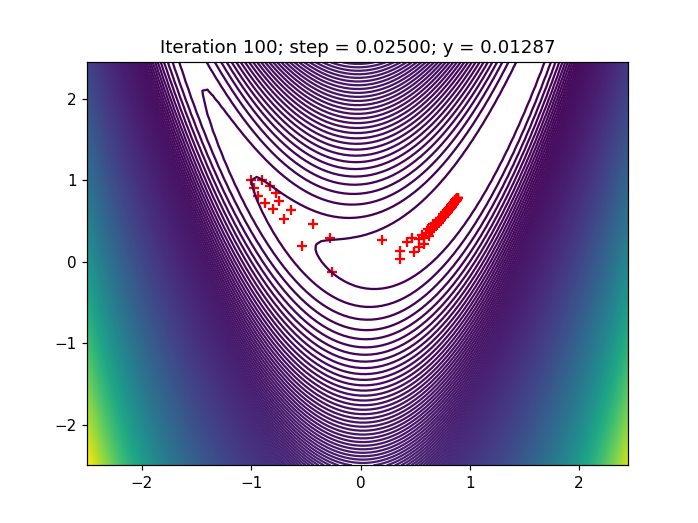

In [7]:
# We instantiate a line searcher
ls = ArmijoLineSearch(c=0.0001, max_step=0.1)

# We instantiate an gradient descent optimizer which uses the line searcher 
opt = LineSearchGD(ls=ls, X0=[-1.0, 1.0], max_iterations=100, eps=1e-6)

# We optimize a function with it's gradient
trace, steps = opt.optimize(f=f, g=g)

# We display the optimizer's progress
fig, ax = plt.subplots()
plt.ion()
plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)

## Non-linear conjugate gradient method

The gradient descent methods that we saw until now had an annoying property in that they all zigzagged towards the minimum. The [conjugate gradient method](https://www.wikiwand.com/en/Conjugate_gradient_method) attempts to remedy to this zigzagging. Here we'll be implementing the [non-linear version](https://www.wikiwand.com/en/Nonlinear_conjugate_gradient_method) as it is much more practical. In this implementation we will be using the Fletcher-Reeves formula for computing $\beta$, but be aware that other formulas exist!

By the way [here is a good explanation](http://www.idi.ntnu.no/~elster/tdt24/tdt24-f09/cg.pdf) of the algorithm.

In [125]:
class ConjugateGD():
    
    def __init__(self, X0, ls, max_iterations, eps):
        self.X0 = np.array(X0, dtype=float)
        self.ls = ls
        self.max_iterations = max_iterations
        self.eps = eps
        
    def optimize(self, f, g):
        
        X = self.X0.copy()
        trace = [X.copy()]
        steps = [0]

        # Compute the first gradient and the first descent direction
        gradient = g(X)
        direction = -gradient
        norm = np.dot(gradient, gradient)

        for _ in range(self.max_iterations):
            
            # Stop if the norm of the gradient is too low
            if norm < self.eps:
                break

            # Find the optimal step size
            step = self.ls.find_step(f, direction, X)

            # Move X along it's gradient
            X += step * direction
            
            # Compute the new gradient
            gradient = g(X)
            
            # Compute the new descent direction
            new_norm = np.dot(gradient, gradient)
            beta = new_norm / norm
            direction = -gradient + beta * direction
            norm = new_norm
        
            # Store the new position and the new step size 
            trace.append(X.copy())
            steps.append(step)

        return np.array(trace), np.array(steps)
    
    
ls = ArmijoLineSearch(c=0.0001, max_step=0.1)
opt = ConjugateGD(ls=ls, X0=[-1.0, 1.0], max_iterations=100, eps=1e-6)
trace, steps = opt.optimize(f=f, g=g)

<IPython.core.display.Javascript object>


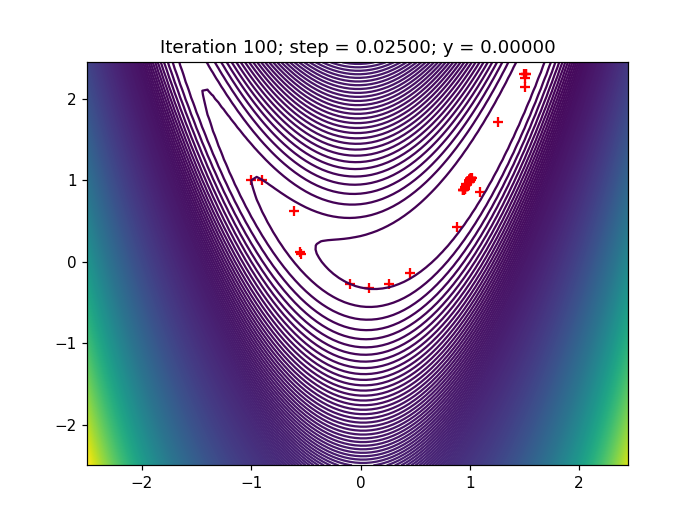

In [126]:
fig, ax = plt.subplots()
plt.ion()

plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)

## Newton's method

The idea of [Newton's method](https://www.wikiwand.com/en/Newton%27s_method) is to use the information contained in the Hessian of `f`. The Hessian is usually denoted as $\nabla^2$ or as $H$. See [this StackExchange thread](https://math.stackexchange.com/questions/609680/newtons-method-intuition) for an intuitive explanation.

In [127]:
class NewtonGD():
    
    def __init__(self, X0, ls, max_iterations, eps):
        self.X0 = np.array(X0, dtype=float)
        self.ls = ls
        self.max_iterations = max_iterations
        self.eps = eps
        
    def optimize(self, f, g, h):
        
        X = self.X0.copy()
        trace = [X.copy()]
        steps = [0]
        
        for _ in range(self.max_iterations):

            # Compute the gradient
            gradient = g(X)
            
            # Stop if the norm of the gradient is too low
            if np.dot(gradient, gradient) < self.eps:
                break
                
            # Compute the Hessian
            hessian = h(X)
            
            # Compute the descent direction
            direction = np.linalg.solve(hessian, -gradient)
            
            # Find the optimal step size
            step = self.ls.find_step(f, direction, X)

            # Move X along the descent direction
            X += step * direction

            # Store the new position and the new step size 
            trace.append(X.copy())
            steps.append(step)

        return np.array(trace), np.array(steps)
    

ls = ArmijoLineSearch(c=0.0001, max_step=1.0)
opt = NewtonGD(ls=ls, X0=[-1.0, 1.0], max_iterations=100, eps=1e-6)
trace, steps = opt.optimize(f=f, g=g, h=h)

<IPython.core.display.Javascript object>


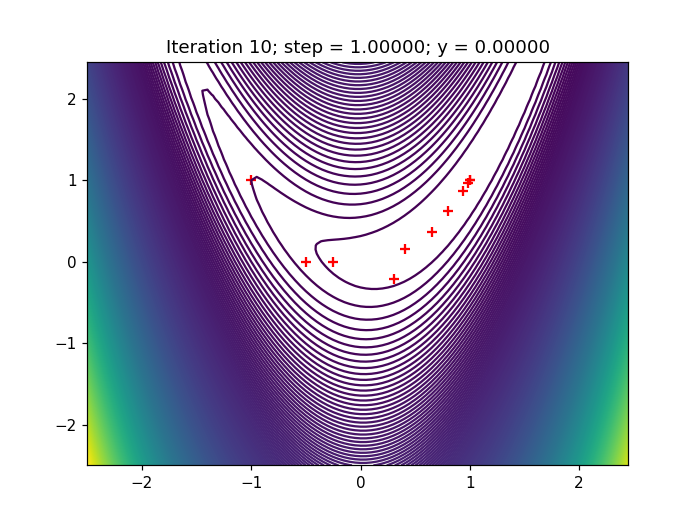

In [128]:
fig, ax = plt.subplots()
plt.ion()

plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)

## Quasi-Newton method

The downside of Newton's method is that the Hessian can be difficult to inverse (especially if you're doing deep learning where there can be millions of parameters!). The idea behind [quasi-Newton methods](https://www.wikiwand.com/en/Quasi-Newton_method) is to approximate the Hessian's inverse using the information on the successive gradients. In other words they try to guess the curvature using finited differences. There exist many ways to compute the approximate Hessian. The first one ever invented was the [DFP formula](https://www.wikiwand.com/en/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula) while arguably the most popular one is the [BFGS method](https://www.wikiwand.com/en/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Nonetheless we can write a generic class that takes as parameter a Hessian approximation method. Each approximation method is provided with the current Hessian approximation, the difference between the current point and the previous point, and the difference between the current gradient and the previous gradient. The first Hessian approximation is the identity matrix $I$.

In [14]:
class QuasiNewtonGD():
    
    def __init__(self, hessian_method, X0, ls, max_iterations, eps):
        self.hessian_method = hessian_method
        self.X0 = np.array(X0, dtype=float)
        self.ls = ls
        self.max_iterations = max_iterations
        self.eps = eps
        
    def optimize(self, f, g):
        
        X = self.X0.copy()
        trace = [X.copy()]
        steps = [0]
        
        # Compute the first gradient
        gradient = g(X)
        
        # Instantiate the first Hessian
        hessian = np.eye(X.size)
        
        for _ in range(self.max_iterations):
            
            # Stop if the norm of the gradient is too low
            if np.dot(gradient, gradient) < self.eps:
                break
                
            # Compute the descent direction
            direction = np.linalg.solve(hessian, -gradient)
            
            # Find the optimal step size
            step = self.ls.find_step(f, direction, X)

            # Move X along the descent direction and memorise X
            X, X_old = X + step * direction, X
            
            # Update the gradient and memorise g
            gradient, gradient_old = g(X), gradient
            
            # Update W
            hessian = self.hessian_method(hessian, X - X_old, gradient - gradient_old)

            # Store the new position and the new step size 
            trace.append(X.copy())
            steps.append(step)

        return np.array(trace), np.array(steps)

The [DFP formula](https://www.wikiwand.com/en/Davidon%E2%80%93Fletcher%E2%80%93Powell_formula) was the first quasi-Newton method ever proposed. This doesn't mean it is the simplest one! The Hessian sThe update formula is:

$$H_{k+1} = H_k - \frac{H_k y_k y_k^T H_k}{y_k^T H_k y_k} + \frac{s_k s_k^T}{y_k^{T} s_k}$$

<IPython.core.display.Javascript object>


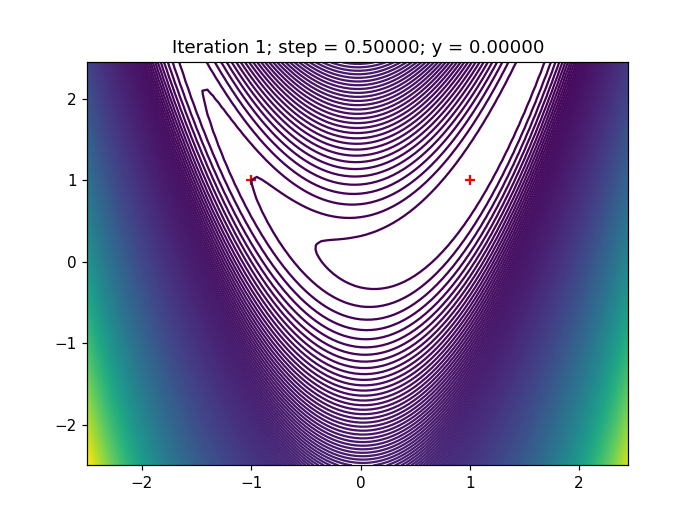

In [31]:
def DFP_update(H, X_diff, g_diff):
    
    s = np.reshape(X_diff, (X_diff.size, 1))
    y = np.reshape(g_diff, (g_diff.size, 1))
    Hy = np.matmul(H, y)
    
    H = H - np.matmul(Hy, Hy.T) / np.matmul(y.T, Hy) + np.matmul(s, s.T) / np.dot(y.T, s)
    
    return H

ls = ArmijoLineSearch(c=0.0001, max_step=1.0)
opt = QuasiNewtonGD(hessian_method=DFP_update, ls=ls, X0=[-1.0, 1.0], max_iterations=100, eps=1e-6)
trace, steps = opt.optimize(f=f, g=g)

fig, ax = plt.subplots()
plt.ion()

plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)

The [BFGS method](https://www.wikiwand.com/en/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) is arguably the most popular quasi-Newton method. The update formula is:

$$H_{k+1} = H_k - \frac{H_k s_k s_k^{T} H_k^{T} }{s_k^{T} H_k s_k} + \frac{y_k y_k^{T}}{y_k^{T} s_k}$$

Notice the similarity (and the differences) with the DFP formula given above.

<IPython.core.display.Javascript object>


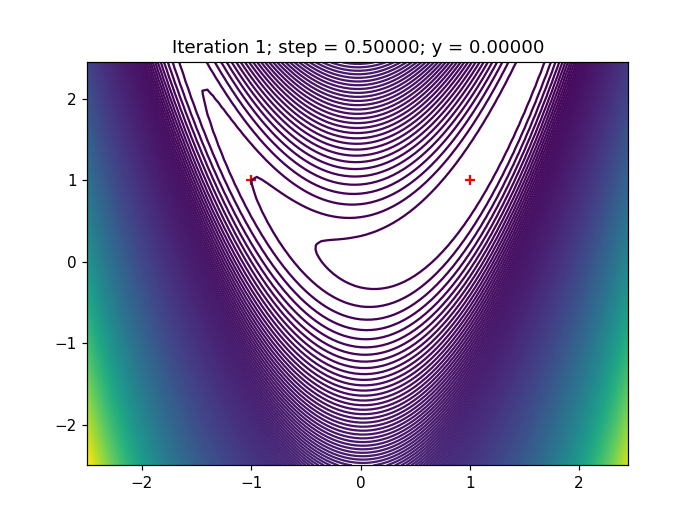

In [32]:
def BFGS_update(H, X_diff, g_diff):
    
    s = np.reshape(X_diff, (X_diff.size, 1))
    y = np.reshape(g_diff, (g_diff.size, 1))
    Hs = np.matmul(H, s)
    
    H = H - np.matmul(Hs, Hs.T) / np.matmul(s.T, Hs) + np.matmul(y, y.T) / np.dot(y.T, s)
    
    return H

ls = ArmijoLineSearch(c=0.0001, max_step=1.0)
opt = QuasiNewtonGD(hessian_method=BFGS_update, ls=ls, X0=[-1.0, 1.0], max_iterations=100, eps=1e-6)
trace, steps = opt.optimize(f=f, g=g)

fig, ax = plt.subplots()
plt.ion()

plot_contour(-2.5, 2.5, -2.5, 2.5, f, ax)
plot_trace(trace, steps, f, ax)